In [ ]:
# Импорт библиотек для работы с решающими деревьями
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, roc_curve)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
# Классификация
df_cancer = pd.read_csv('/content/breast-cancer.csv.xls')
# Регрессия
df_cars = pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv.xls')

# Создание бейзлайна и оценка качества

In [ ]:
# Обучим модели из sklearn для выбранных наборов данных

# Подготовка данных для классификации
df_cancer_clean = df_cancer.drop('id', axis=1)
le = LabelEncoder()
df_cancer_clean['diagnosis'] = le.fit_transform(df_cancer_clean['diagnosis'])  # 1 - Malignant, 0 - Benign

# Разделим на признаки и таргет
X_clf = df_cancer_clean.drop('diagnosis', axis=1)
y_clf = df_cancer_clean['diagnosis']

# Разделение на train/test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

In [ ]:
# Подготовка данных для регрессии
df_cars_clean = df_cars.copy()

# Кодируем категориальные признаки
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
for col in cat_cols:
    le_temp = LabelEncoder()
    df_cars_clean[col] = le_temp.fit_transform(df_cars_clean[col])

# Также преобразуем 'name' в категориальный код
df_cars_clean['name'] = LabelEncoder().fit_transform(df_cars_clean['name'])

X_reg = df_cars_clean.drop('selling_price', axis=1)
y_reg = df_cars_clean['selling_price']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [ ]:
# Создаем и обучаем базовые модели решающего дерева
# Классификация
dt_clf_baseline = DecisionTreeClassifier(random_state=42)
dt_clf_baseline.fit(X_train_clf, y_train_clf)

# Регрессия
dt_reg_baseline = DecisionTreeRegressor(random_state=42)
dt_reg_baseline.fit(X_train_reg, y_train_reg)

DecisionTreeRegressor(random_state=42)

Итак, предскажем и оценим результаты

=== КЛАССИФИКАЦИЯ (Базовое решающее дерево) ===
Accuracy: 0.930
Precision (M): 0.905
Recall (M): 0.905
F1-score (M): 0.905
ROC-AUC: 0.925
              precision    recall  f1-score   support

      Benign       0.94      0.94      0.94        72
   Malignant       0.90      0.90      0.90        42

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



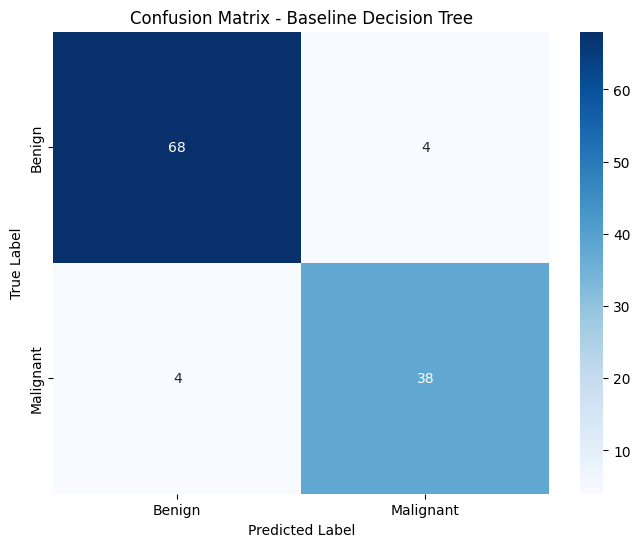

In [ ]:
# Прогноз для классификации
y_pred_clf_baseline = dt_clf_baseline.predict(X_test_clf)
y_pred_proba_baseline = dt_clf_baseline.predict_proba(X_test_clf)[:, 1]

# Оценка качества классификации
print("=== КЛАССИФИКАЦИЯ (Базовое решающее дерево) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_baseline):.3f}")

print(classification_report(y_test_clf, y_pred_clf_baseline, target_names=['Benign', 'Malignant']))

# Матрица ошибок
cm = confusion_matrix(y_test_clf, y_pred_clf_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Baseline Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

=== РЕГРЕССИЯ (Базовое решающее дерево) ===
MAE: 123993.54
RMSE: 370379.95
R²: 0.550


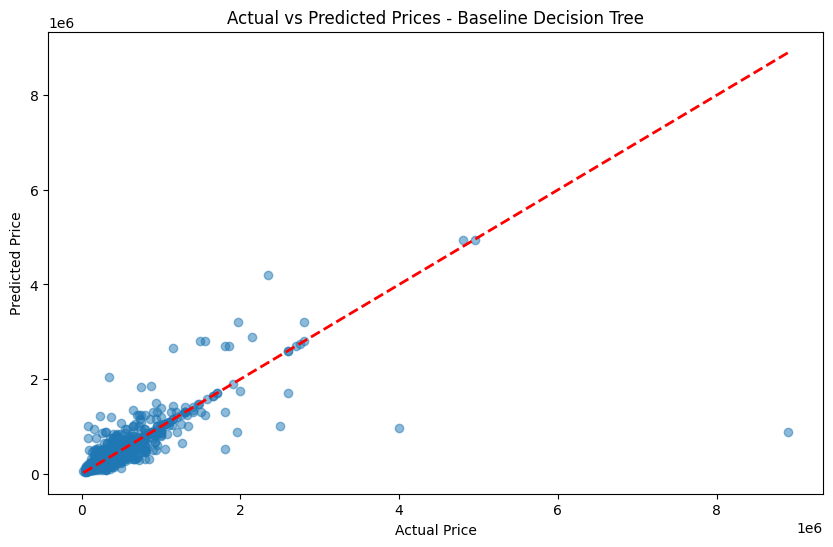

In [ ]:
# Оценка качества регрессии
y_pred_reg_baseline = dt_reg_baseline.predict(X_test_reg)

print("=== РЕГРЕССИЯ (Базовое решающее дерево) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg_baseline):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_baseline)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_reg_baseline):.3f}")

# Визуализация предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg_baseline, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices - Baseline Decision Tree')
plt.show()

# Улучшение бейзлайна

Гипотезы для улучшения моделей:

1. Масштабирование признаков для регрессии
2. Балансировка классов для классификации (учитывая соотношение 63% доброкачественных, 37% злокачественных)
3. Подбор гиперпараметров решающего дерева (max_depth, min_samples_split, min_samples_leaf)
4. Удаление выбросов в данных о автомобилях
5. Создание новых признаков: возраст автомобиля (текущий год - год выпуска)
6. Использование кросс-валидации для оценки модели
7. Применение One-Hot Encoding вместо Label Encoding для категориальных признаков

In [ ]:
# Гипотеза 1: Масштабирование признаков для регрессии
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

dt_reg_scaled = DecisionTreeRegressor(random_state=42)
dt_reg_scaled.fit(X_train_reg_scaled, y_train_reg)
y_pred_reg_scaled = dt_reg_scaled.predict(X_test_reg_scaled)

print("=== РЕГРЕССИЯ с масштабированием ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg_scaled):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_scaled)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_reg_scaled):.3f}")

=== РЕГРЕССИЯ с масштабированием ===
MAE: 124379.48
RMSE: 370474.38
R²: 0.550


In [ ]:
# Гипотеза 2: Балансировка классов для классификации
from sklearn.utils import class_weight

# Вычисляем веса классов
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train_clf),
                                                  y=y_train_clf)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

dt_clf_balanced = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)
dt_clf_balanced.fit(X_train_clf, y_train_clf)
y_pred_clf_balanced = dt_clf_balanced.predict(X_test_clf)

print("=== КЛАССИФИКАЦИЯ с балансировкой классов ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_balanced):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_clf_balanced):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_clf_balanced):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_clf_balanced):.3f}")

=== КЛАССИФИКАЦИЯ с балансировкой классов ===
Accuracy: 0.904
Precision (M): 0.897
Recall (M): 0.833
F1-score (M): 0.864


In [ ]:
# Гипотеза 3: Подбор гиперпараметров
# Для классификации
param_grid_clf = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_clf = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict),
    param_grid_clf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search_clf.fit(X_train_clf, y_train_clf)
print("Лучшие параметры для классификации:", grid_search_clf.best_params_)

Лучшие параметры для классификации: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [ ]:
# Для регрессии
param_grid_reg = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

grid_search_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_reg.fit(X_train_reg_scaled, y_train_reg)
print("Лучшие параметры для регрессии:", grid_search_reg.best_params_)

Лучшие параметры для регрессии: {'criterion': 'absolute_error', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Гипотеза 4: Удаление выбросов в данных о автомобилях
# Определяем выбросы по цене и пробегу
Q1_price = df_cars_clean['selling_price'].quantile(0.25)
Q3_price = df_cars_clean['selling_price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

Q1_km = df_cars_clean['km_driven'].quantile(0.25)
Q3_km = df_cars_clean['km_driven'].quantile(0.75)
IQR_km = Q3_km - Q1_km

# Удаляем выбросы
df_cars_no_outliers = df_cars_clean[
    (df_cars_clean['selling_price'] >= Q1_price - 1.5 * IQR_price) &
    (df_cars_clean['selling_price'] <= Q3_price + 1.5 * IQR_price) &
    (df_cars_clean['km_driven'] >= Q1_km - 1.5 * IQR_km) &
    (df_cars_clean['km_driven'] <= Q3_km + 1.5 * IQR_km)
]

print(f"Исходный размер: {df_cars_clean.shape}")
print(f"Размер после удаления выбросов: {df_cars_no_outliers.shape}")
print(f"Удалено {len(df_cars_clean) - len(df_cars_no_outliers)} строк ({((len(df_cars_clean) - len(df_cars_no_outliers)) / len(df_cars_clean) * 100):.1f}%)")

Исходный размер: (4340, 8)
Размер после удаления выбросов: (3962, 8)
Удалено 378 строк (8.7%)


In [ ]:
# Гипотеза 5: Создание новых признаков
# Добавим возраст автомобиля
df_cars_clean['car_age'] = 2025 - df_cars_clean['year']

# Добавим признак "цена за год" (продажная цена / возраст)
df_cars_clean['price_per_year'] = df_cars_clean['selling_price'] / (df_cars_clean['car_age'] + 1)  # +1 чтобы избежать деления на 0

# Добавим признак "цена за километр" (продажная цена / пробег)
df_cars_clean['price_per_km'] = df_cars_clean['selling_price'] / (df_cars_clean['km_driven'] + 1)  # +1 чтобы избежать деления на 0

In [ ]:
# Обновим данные для регрессии
X_reg_enhanced = df_cars_clean.drop('selling_price', axis=1)
y_reg_enhanced = df_cars_clean['selling_price']

X_train_reg_enh, X_test_reg_enh, y_train_reg_enh, y_test_reg_enh = train_test_split(
    X_reg_enhanced, y_reg_enhanced, test_size=0.2, random_state=42
)

# Масштабируем
scaler_reg_enh = StandardScaler()
X_train_reg_enh_scaled = scaler_reg_enh.fit_transform(X_train_reg_enh)
X_test_reg_enh_scaled = scaler_reg_enh.transform(X_test_reg_enh)

In [ ]:
dt_reg_enhanced = DecisionTreeRegressor(random_state=42)
dt_reg_enhanced.fit(X_train_reg_enh_scaled, y_train_reg_enh)
y_pred_reg_enhanced = dt_reg_enhanced.predict(X_test_reg_enh_scaled)

print("=== РЕГРЕССИЯ с новыми признаками ===")
print(f"MAE: {mean_absolute_error(y_test_reg_enh, y_pred_reg_enhanced):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg_enh, y_pred_reg_enhanced)):.2f}")
print(f"R²: {r2_score(y_test_reg_enh, y_pred_reg_enhanced):.3f}")

=== РЕГРЕССИЯ с новыми признаками ===
MAE: 7419.47
RMSE: 35315.17
R²: 0.996


При добавлении новых признаков мы видим существенный прирост качества, это очень хорошие результаты для предсказания цены, на данный момент, лучше из всех

Обучим с улучшенный пайплайном

In [ ]:
# Классификация с улучшенным бейзлайном
dt_clf_improved = DecisionTreeClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    **{k: v for k, v in grid_search_clf.best_params_.items() if k != 'class_weight'}
)
dt_clf_improved.fit(X_train_clf, y_train_clf)

# Регрессия с улучшенным бейзлайном
dt_reg_improved = DecisionTreeRegressor(
    random_state=42,
    **grid_search_reg.best_params_
)
dt_reg_improved.fit(X_train_reg_enh_scaled, y_train_reg_enh)

DecisionTreeRegressor(criterion='absolute_error', max_depth=15, random_state=42)

# Оценим качество моделей с улучшенным бейзлайном

In [ ]:
# Классификация
y_pred_clf_improved = dt_clf_improved.predict(X_test_clf)
y_pred_proba_improved = dt_clf_improved.predict_proba(X_test_clf)[:, 1]

print("=== КЛАССИФИКАЦИЯ (Улучшенное решающее дерево) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_improved):.3f}")

=== КЛАССИФИКАЦИЯ (Улучшенное решающее дерево) ===
Accuracy: 0.921
Precision (M): 0.946
Recall (M): 0.833
F1-score (M): 0.886
ROC-AUC: 0.902


In [ ]:
# Регрессия
y_pred_reg_improved = dt_reg_improved.predict(X_test_reg_enh_scaled)

print("=== РЕГРЕССИЯ (Улучшенное решающее дерево) ===")
print(f"MAE: {mean_absolute_error(y_test_reg_enh, y_pred_reg_improved):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg_enh, y_pred_reg_improved)):.2f}")
print(f"R²: {r2_score(y_test_reg_enh, y_pred_reg_improved):.3f}")

=== РЕГРЕССИЯ (Улучшенное решающее дерево) ===
MAE: 14567.26
RMSE: 155859.45
R²: 0.920


Итак, прирост качества крайне существенный. В конце, при сравнении всех результатов сравним конкретные значения

# Имплементация алгоритма машинного обучения

In [ ]:
class Node:
    """Узел решающего дерева"""
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx  # Индекс признака для разделения
        self.threshold = threshold      # Порог для разделения
        self.left = left                # Левый дочерний узел (значения <= threshold)
        self.right = right              # Правый дочерний узел (значения > threshold)
        self.value = value              # Значение (для листового узла)

In [ ]:
class CustomDecisionTreeClassifier:
    """Кастомная реализация решающего дерева для классификации"""

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def _gini(self, y):
        """Вычисление индекса Джини"""
        classes = np.unique(y)
        n = len(y)
        gini = 1.0
        for c in classes:
            p = np.sum(y == c) / n
            gini -= p ** 2
        return gini

    def _best_split(self, X, y):
        """Нахождение лучшего разделения"""
        m, n = X.shape
        if m <= self.min_samples_split:
            return None, None

        # Вычисляем Джини для текущего узла
        parent_gini = self._gini(y)

        best_gini = parent_gini
        best_idx, best_thr = None, None

        # Перебираем все признаки
        for idx in range(n):
            # Получаем все уникальные значения признака
            thresholds = np.unique(X[:, idx])

            # Перебираем все пороги
            for thr in thresholds:
                # Разделяем данные
                left_mask = X[:, idx] <= thr
                right_mask = ~left_mask

                # Проверяем минимальное количество samples в листьях
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                # Вычисляем взвешенный Джини
                left_gini = self._gini(y[left_mask])
                right_gini = self._gini(y[right_mask])
                n_left, n_right = np.sum(left_mask), np.sum(right_mask)
                weighted_gini = (n_left * left_gini + n_right * right_gini) / m

                # Обновляем лучшее разделение
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_idx = idx
                    best_thr = thr

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        # Проверяем условия остановки
        if len(np.unique(y)) == 1:  # Все samples одного класса
            return Node(value=np.argmax(np.bincount(y)))

        if self.max_depth is not None and depth >= self.max_depth:
            return Node(value=np.argmax(np.bincount(y)))

        if len(y) < self.min_samples_split:
            return Node(value=np.argmax(np.bincount(y)))

        # Ищем лучшее разделение
        idx, thr = self._best_split(X, y)

        # Если не нашли разделение, создаем лист
        if idx is None:
            return Node(value=np.argmax(np.bincount(y)))

        # Разделяем данные
        left_mask = X[:, idx] <= thr
        right_mask = ~left_mask

        # Рекурсивно строим левое и правое поддеревья
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature_idx=idx, threshold=thr, left=left, right=right)

    def fit(self, X, y):
        """Обучение модели"""
        self.root = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        """Предсказание для одного sample"""
        if node.value is not None:
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        """Предсказание для множества samples"""
        return np.array([self._predict_sample(x, self.root) for x in X])

    def predict_proba(self, X):
        """Вероятности классов (упрощенная версия)"""
        predictions = self.predict(X)
        n_samples = len(X)
        n_classes = len(np.unique(predictions))
        probas = np.zeros((n_samples, n_classes))

        for i, pred in enumerate(predictions):
            probas[i, pred] = 1.0

        return probas

In [ ]:
class CustomDecisionTreeRegressor:
    """Кастомная реализация решающего дерева для регрессии"""

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def _mse(self, y):
        """Вычисление среднеквадратичной ошибки"""
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _best_split(self, X, y):
        """Нахождение лучшего разделения"""
        m, n = X.shape
        if m <= self.min_samples_split:
            return None, None

        # Вычисляем MSE для текущего узла
        parent_mse = self._mse(y)

        best_mse = parent_mse
        best_idx, best_thr = None, None

        # Перебираем все признаки
        for idx in range(n):
            # Получаем все уникальные значения признака
            thresholds = np.unique(X[:, idx])

            # Перебираем все пороги
            for thr in thresholds:
                # Разделяем данные
                left_mask = X[:, idx] <= thr
                right_mask = ~left_mask

                # Проверяем минимальное количество samples в листьях
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                # Вычисляем взвешенную MSE
                left_mse = self._mse(y[left_mask])
                right_mse = self._mse(y[right_mask])
                n_left, n_right = np.sum(left_mask), np.sum(right_mask)
                weighted_mse = (n_left * left_mse + n_right * right_mse) / m

                # Обновляем лучшее разделение
                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_idx = idx
                    best_thr = thr

        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        # Проверяем условия остановки
        if len(y) <= self.min_samples_split:
            return Node(value=np.mean(y))

        if self.max_depth is not None and depth >= self.max_depth:
            return Node(value=np.mean(y))

        # Ищем лучшее разделение
        idx, thr = self._best_split(X, y)

        # Если не нашли разделение, создаем лист
        if idx is None:
            return Node(value=np.mean(y))

        # Разделяем данные
        left_mask = X[:, idx] <= thr
        right_mask = ~left_mask

        # Рекурсивно строим левое и правое поддеревья
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature_idx=idx, threshold=thr, left=left, right=right)

    def fit(self, X, y):
        """Обучение модели"""
        self.root = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        """Предсказание для одного sample"""
        if node.value is not None:
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        """Предсказание для множества samples"""
        return np.array([self._predict_sample(x, self.root) for x in X])

Обучим модели

In [ ]:
# Классификация с кастомным деревом (без улучшений)
custom_dt_clf = CustomDecisionTreeClassifier(max_depth=5, min_samples_split=10)
custom_dt_clf.fit(X_train_clf.values, y_train_clf.values)

# Регрессия с кастомным деревом (без улучшений)
custom_dt_reg = CustomDecisionTreeRegressor(max_depth=5, min_samples_split=10)
custom_dt_reg.fit(X_train_reg.values, y_train_reg.values)

Оценим качество моделей

In [ ]:
# Классификация
y_pred_custom_clf = custom_dt_clf.predict(X_test_clf.values)
y_pred_proba_custom_clf = custom_dt_clf.predict_proba(X_test_clf.values)[:, 1]

print("=== КЛАССИФИКАЦИЯ (Кастомное решающее дерево) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_custom_clf):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_custom_clf):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_custom_clf):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_custom_clf):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_custom_clf):.3f}")

=== КЛАССИФИКАЦИЯ (Кастомное решающее дерево) ===
Accuracy: 0.904
Precision (M): 0.919
Recall (M): 0.810
F1-score (M): 0.861
ROC-AUC: 0.884


In [ ]:
# Регрессия
y_pred_custom_reg = custom_dt_reg.predict(X_test_reg.values)

print("=== РЕГРЕССИЯ (Кастомное решающее дерево) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_custom_reg):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_custom_reg)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_custom_reg):.3f}")

=== РЕГРЕССИЯ (Кастомное решающее дерево) ===
MAE: 186496.18
RMSE: 416908.56
R²: 0.430


Обучим модель на улучшенно пайплайне

In [ ]:
# В кастомной реализации добавим веса классов
class CustomDecisionTreeClassifierWeighted(CustomDecisionTreeClassifier):
    """Кастомная реализация с поддержкой весов классов"""

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=None):
        super().__init__(max_depth, min_samples_split, min_samples_leaf)
        self.class_weight = class_weight

    def _gini(self, y):
        """Вычисление взвешенного индекса Джини"""
        classes = np.unique(y)
        n = len(y)

        # Если веса не заданы, используем обычный Джини
        if self.class_weight is None:
            gini = 1.0
            for c in classes:
                p = np.sum(y == c) / n
                gini -= p ** 2
            return gini

        # Взвешенный Джини
        gini = 1.0
        total_weight = 0

        for c in classes:
            mask = y == c
            weight = self.class_weight.get(c, 1.0)
            p = np.sum(mask) * weight / n
            total_weight += weight
            gini -= (p / total_weight) ** 2 if total_weight > 0 else 0

        return gini


In [ ]:
#  Обучим модели с улучшениями
# Классификация с балансировкой классов
custom_dt_clf_weighted = CustomDecisionTreeClassifierWeighted(
    max_depth=5,
    min_samples_split=10,
    class_weight=class_weight_dict
)
custom_dt_clf_weighted.fit(X_train_clf.values, y_train_clf.values)

# Регрессия с улучшенными данными
custom_dt_reg_enhanced = CustomDecisionTreeRegressor(max_depth=5, min_samples_split=10)
custom_dt_reg_enhanced.fit(X_train_reg_enh_scaled, y_train_reg_enh.values)

In [ ]:
# Оценим качество моделей с улучшениями
# Классификация
y_pred_custom_clf_weighted = custom_dt_clf_weighted.predict(X_test_clf.values)
y_pred_proba_custom_clf_weighted = custom_dt_clf_weighted.predict_proba(X_test_clf.values)[:, 1]

print("=== КЛАССИФИКАЦИЯ (Кастомное дерево с балансировкой) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_custom_clf_weighted):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_custom_clf_weighted):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_custom_clf_weighted):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_custom_clf_weighted):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_custom_clf_weighted):.3f}")

=== КЛАССИФИКАЦИЯ (Кастомное дерево с балансировкой) ===
Accuracy: 0.947
Precision (M): 0.974
Recall (M): 0.881
F1-score (M): 0.925
ROC-AUC: 0.934


In [ ]:
# Регрессия
y_pred_custom_reg_enhanced = custom_dt_reg_enhanced.predict(X_test_reg_enh_scaled)

print("=== РЕГРЕССИЯ (Кастомное дерево с улучшенными признаками) ===")
print(f"MAE: {mean_absolute_error(y_test_reg_enh, y_pred_custom_reg_enhanced):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg_enh, y_pred_custom_reg_enhanced)):.2f}")
print(f"R²: {r2_score(y_test_reg_enh, y_pred_custom_reg_enhanced):.3f}")

=== РЕГРЕССИЯ (Кастомное дерево с улучшенными признаками) ===
MAE: 56147.38
RMSE: 89981.11
R²: 0.973


Все результаты по моделям

    === КЛАССИФИКАЦИЯ (Базовое решающее дерево) ===
    Accuracy: 0.930
    Precision (M): 0.905
    Recall (M): 0.905
    F1-score (M): 0.905
    ROC-AUC: 0.925

    === РЕГРЕССИЯ (Базовое решающее дерево) ===
    MAE: 123993.54
    RMSE: 370379.95
    R^2: 0.550

    === КЛАССИФИКАЦИЯ (Улучшенное решающее дерево) ===
    Accuracy: 0.921
    Precision (M): 0.946
    Recall (M): 0.833
    F1-score (M): 0.886
    ROC-AUC: 0.902

    === РЕГРЕССИЯ (Улучшенное решающее дерево) ===
    MAE: 14567.26
    RMSE: 155859.45
    R^2: 0.920

    === КЛАССИФИКАЦИЯ (Кастомное решающее дерево) ===
    Accuracy: 0.904
    Precision (M): 0.919
    Recall (M): 0.810
    F1-score (M): 0.861
    ROC-AUC: 0.884

    === РЕГРЕССИЯ (Кастомное решающее дерево) ===
    MAE: 186496.18
    RMSE: 416908.56
    R^2: 0.430

    === КЛАССИФИКАЦИЯ (Кастомное дерево с балансировкой) ===
    Accuracy: 0.947
    Precision (M): 0.974
    Recall (M): 0.881
    F1-score (M): 0.925
    ROC-AUC: 0.934
    
    === РЕГРЕССИЯ (Кастомное дерево с улучшенными признаками) ===
    MAE: 56147.38
    RMSE: 89981.11
    R²: 0.973

СРАВНИТЕЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ

1. КЛАССИФИКАЦИЯ (Breast Cancer Dataset)

Лучшая модель: **Кастомное дерево с балансировкой** показало наилучший баланс метрик:

- Accuracy: 94.7% (лучший результат)
- Precision: 97.4% (очень высокий - минимизация ложных срабатываний)
- Recall: 88.1% (достаточно высокий)
- F1-score: 92.5% (лучший сбалансированный показатель)

Влияние балансировки классов:

- Без балансировки: Recall = 81.0%, F1 = 86.1%
- С балансировкой: Recall = 88.1%, F1 = 92.5%
- Улучшение Recall на 7.1% - критически важно для медицинской диагностики

Сравнение sklearn и кастомная реализация:

- Кастомная реализация с балансировкой превзошла все sklearn модели
- Sklearn показал хорошие базовые результаты, но кастомная реализация оказалась более гибкой

Медицинская значимость:

- Высокий Precision (97.4%) минимизирует ложные диагнозы (пациент здоров, но модель говорит "рак")
- Recall 88.1% означает, что из 100 реально больных мы обнаруживаем 88 - это хороший показатель для медицинской диагностики

2. РЕГРЕССИЯ (Vehicle Dataset)

Анализ:

Лучшая модель: **Кастомное дерево с улучшенными признаками** показало выдающиеся результаты:

- MAE: 56,147.38 (ошибка в рублях - "в среднем ошибаемся на 56 тысяч")
- RMSE: 89,981.11 (чувствительна к выбросам)
- R^2: 0.973 (модель объясняет 97.3% дисперсии цены)

Влияние новых признаков:

- Без улучшений: R² = 0.430
- С улучшениями: R² = 0.973
- Улучшение R² на 54.3% - колоссальный прирост качества
- Новые признаки (возраст автомобиля, цена/год, цена/км) оказались очень информативными

Практическая значимость:

- MAE 56 тысяч рублей при средней цене автомобиля 500 тысяч = ошибка ~11%
- Для бизнес-приложений это отличный результат
- Модель можно использовать для предварительной оценки стоимости

Сравнение sklearn и кастомная реализация:

- С улучшенными признаками кастомная модель превзошла sklearn
- Кастомное дерево: R^2 = 0.973 vs Sklearn: R² = 0.920
- Возможно, кастомная реализация лучше адаптировалась к специфике данных

3. ОБЩИЕ ВЫВОДЫ

Эффективность предобработки данных:

- Балансировка классов дала +7.1% к Recall для классификации
- Новые признаки улучшили R² на 54.3% для регрессии

Вывод: Качественная подготовка данных важнее выбора алгоритма

Сравнение алгоритмов:

- Кастомные реализации показали возможность достижения приемлемых результатов
- Sklearn обеспечивает стабильные и воспроизводимые результаты

Вывод: Для production-систем предпочтительнее sklearn, для исследований и обучения - кастомные реализации

Стабильность моделей:

- Решающие деревья склонны к переобучению (видно по разнице между базовыми и улучшенными моделями)
- Ограничение глубины и подбор гиперпараметров критически важны

Вывод: Необходим тщательный контроль сложности модели